# Notebook to evaluate the 3D models (predict and visualize the full scans)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
from glob import glob
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import albumentations as A
from PIL import Image
import pickle
import gc
from resnet import *

In [2]:
size = 1024
depth = 16
start_depth = 65 // 2 - depth // 2
model_depth = 34

In [3]:
folder = '/home/olli/Projects/Kaggle/Vesuvius'
folder_data = os.path.join(folder, 'Data_New', 'train')

In [4]:
model_1 = ResNet_3D_to_2D(model_depth=model_depth)
model_2 = ResNet_3D_to_2D(model_depth=model_depth)
model_3 = ResNet_3D_to_2D(model_depth=model_depth)

In [5]:
model_1.eval()
model_2.eval()
model_3.eval()

ResNet_3D_to_2D(
  (encoder): ResNet(
    (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(1, 2, 2), padding=(3, 3, 3), bias=False)
    (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1), dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (b

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [7]:
model_weight_paths = [os.path.join(folder, 'Weights', f'Model_{i}_3DCNN_ResNet_3_Final_1024_Opt_HP.pth') \
                      for i in range(1, 4)]

In [8]:
model_1.load_state_dict(torch.load(model_weight_paths[0]))
model_2.load_state_dict(torch.load(model_weight_paths[1]))
model_3.load_state_dict(torch.load(model_weight_paths[2]))

<All keys matched successfully>

# Make the prediction only for each model on the validation fragment!

In [9]:
transforms = A.Compose([
    A.Normalize(mean=[0] * depth, std=[1] * depth)])

In [10]:
    class Data(torch.utils.data.Dataset):
        def __init__(self, files, transform=transforms):
            self.files = files
            self.transform=transform

        def __len__(self):
            return len(self.files)

        def __getitem__(self, index):
            file = self.files[index]

            with open(file, 'rb') as f:
                data = pickle.load(f)

            scan, h, w = data

            if self.transform:
                augmented = self.transform(image=scan)

            scan = augmented['image']

            scan = torch.tensor(scan).permute(2, 0, 1).type(torch.float32)

            scan = scan.unsqueeze(0)

            return scan, h, w

In [11]:
def evaluate_fragment(name, model, threshold):
    assert name in [1, 2, 3]
    
    # load the fragment
    path = os.path.join(folder_data, str(name))
    
    path_mask = os.path.join(path, 'mask.png')
    path_volumes = glob(path + '/surface_volume/*.tif')
    path_volumes.sort()
    if depth != 65:  # take the specified number from the middle
        path_volumes = path_volumes[start_depth:start_depth + depth]
    mask = cv2.imread(path_mask, cv2.IMREAD_GRAYSCALE)
    height, width = mask.shape
    
    # Idea: Pad the volume and mask with pixels so its perfectly dividable by size
    add_height = size - height % size  # values to add
    add_width = size - width % size
    
    assert (add_height + height) % size == 0
    assert (add_width + width) % size == 0
    
    # Then pad size//4 around again to only use the center of the predicitons (for border regions too)
    add_height = add_height + size // 2
    add_width = add_width + size // 2
    
    # where to assign the mask/scan
    start_height = add_height // 2
    start_width = add_width // 2
    
    new_height = height + add_height
    new_width = width + add_width
    
    # create the new mask and assign the original one
    new_mask = np.zeros((new_height, new_width), dtype=np.uint8)
    new_mask[start_height:start_height + height, start_width: start_width + width] = mask
    
    
    # now load the scans and put them in the correct place / depth
    scan = np.zeros((new_height, new_width, depth), dtype=np.uint8)
    for layer_num in range(depth):
        path_layer = path_volumes[layer_num] # current layer path
        layer = cv2.imread(path_layer, cv2.IMREAD_GRAYSCALE) # load it
        scan[start_height: start_height + height, start_width: start_width + width, layer_num] = layer  # assign it
    
    # save all crops in a folder
    save_path = f'{folder}/tmp/{name}'
    if not os.path.exists(save_path):
        os.makedirs(save_path, exist_ok=True)
    
    index = 0  # index for unique filenames
    
    # now loop over all possible height and width values and save them in a folder in /tmp if mask has a value >1
    print('Preprocessing Data...')
    for h in tqdm(range(0, new_height - size // 2, size // 2)):
        for w in range(0, new_width - size // 2, size // 2):
            mask_crop = new_mask[h: h + size, w: w + size]
            
            if mask_crop.max() <= 0:  # no scan in it -> dont save
                continue
            else:  # save the scan for prediction
                crop_scan = scan[h: h + size, w: w + size, :]
                assert crop_scan.shape == (size, size, depth)
                # now save the crop with the information to assign it after prediction
                tuple_save = (crop_scan, h, w)
                path_file = os.path.join(save_path, f'{str(index)}.pickle')
                with open(path_file, 'wb') as f:
                    pickle.dump(tuple_save, f)
                
                index += 1  # increase index if a file got saved

    model.to(device)
    
    # use start and end to only assign the middle pro predictions
    filt = np.zeros((size, size))
    start = size // 4  # start at 25%
    end = 3 * size // 4  # end at 75%
    filt[start:end, start:end] = 1  # middle with ones
    
    files = glob(save_path + '/*pickle')
    print(f'Done;\nPredicting {len(files)} Files...')
    
    ds = Data(files=files)
    dl = torch.utils.data.DataLoader(ds, batch_size=2, num_workers=16, pin_memory=False)
    
    mask = mask / 255.
    new_mask = new_mask / 255.
    
    new_label = np.zeros((new_height, new_width))  # label to assign the predictions to

    for index, (X, H, W) in enumerate(tqdm(dl)):  # Scan, start height of crop, start width of crop
        with torch.inference_mode():
            X = X.to(device)
            preds = model(X)

        # loop over all predictions / heights / widths and assign them
        for pred, h, w in zip(preds, H, W):
            pred = torch.where(pred > threshold, 1., 0.).float().cpu().numpy()  # threshold
            pred = pred.squeeze(0)
            pred = pred[start:end, start:end]  # only the middle; now shape (size//2, size//2)
            #h = h.cpu().numpy()
            #w = w.cpu().numpy()
            
            
            # calculate the values on where to assign the middle
            start_label_height = h + start
            end_label_height = h + end
            start_label_width = w + start
            end_label_width = w + end

            # assign it
            new_label[start_label_height:end_label_height, start_label_width:end_label_width] = pred
    
    # after all predictions are made remove everything outside the scan
    new_label = new_label * new_mask
    
    # now crop out the smaller mask with the original shape
    label = new_label[start_height: start_height + height, start_width: start_width + width]
    #label = np.array(label)
    label_height, label_width = label.shape
    mask_height, mask_width = mask.shape
    assert label_height == mask_height
    assert label_width == mask_width
    
    # just to make sure 
    label = label * mask
    
    # load the original label for comparison
    path_original = os.path.join(path, 'inklabels.png')
    label_original = cv2.imread(path_original, cv2.IMREAD_GRAYSCALE)
    
    label_save_path = os.path.join(folder, 'Figures', f'{name}_Prediction_3DCNN.png')
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(int(2*width/600), int(height/600)))
    ax[0].imshow(label, cmap='gray')
    ax[1].imshow(label_original, cmap='gray')
    ax[0].axis('off')
    ax[1].axis('off')
    ax[0].set_title('Prediction:', fontsize=50, fontweight='bold')
    ax[1].set_title('Ground Truth:', fontsize=50, fontweight='bold')
    fig.tight_layout()
    fig.patch.set_facecolor('white')
    plt.show()
    fig.savefig(label_save_path, bbox_inches='tight')
    
    del mask
    del new_mask
    del label
    del new_label

    gc.collect()
    torch.cuda.empty_cache()

Preprocessing Data...


  0%|          | 0/16 [00:00<?, ?it/s]

Done;
Predicting 164 Files...


  0%|          | 0/82 [00:00<?, ?it/s]

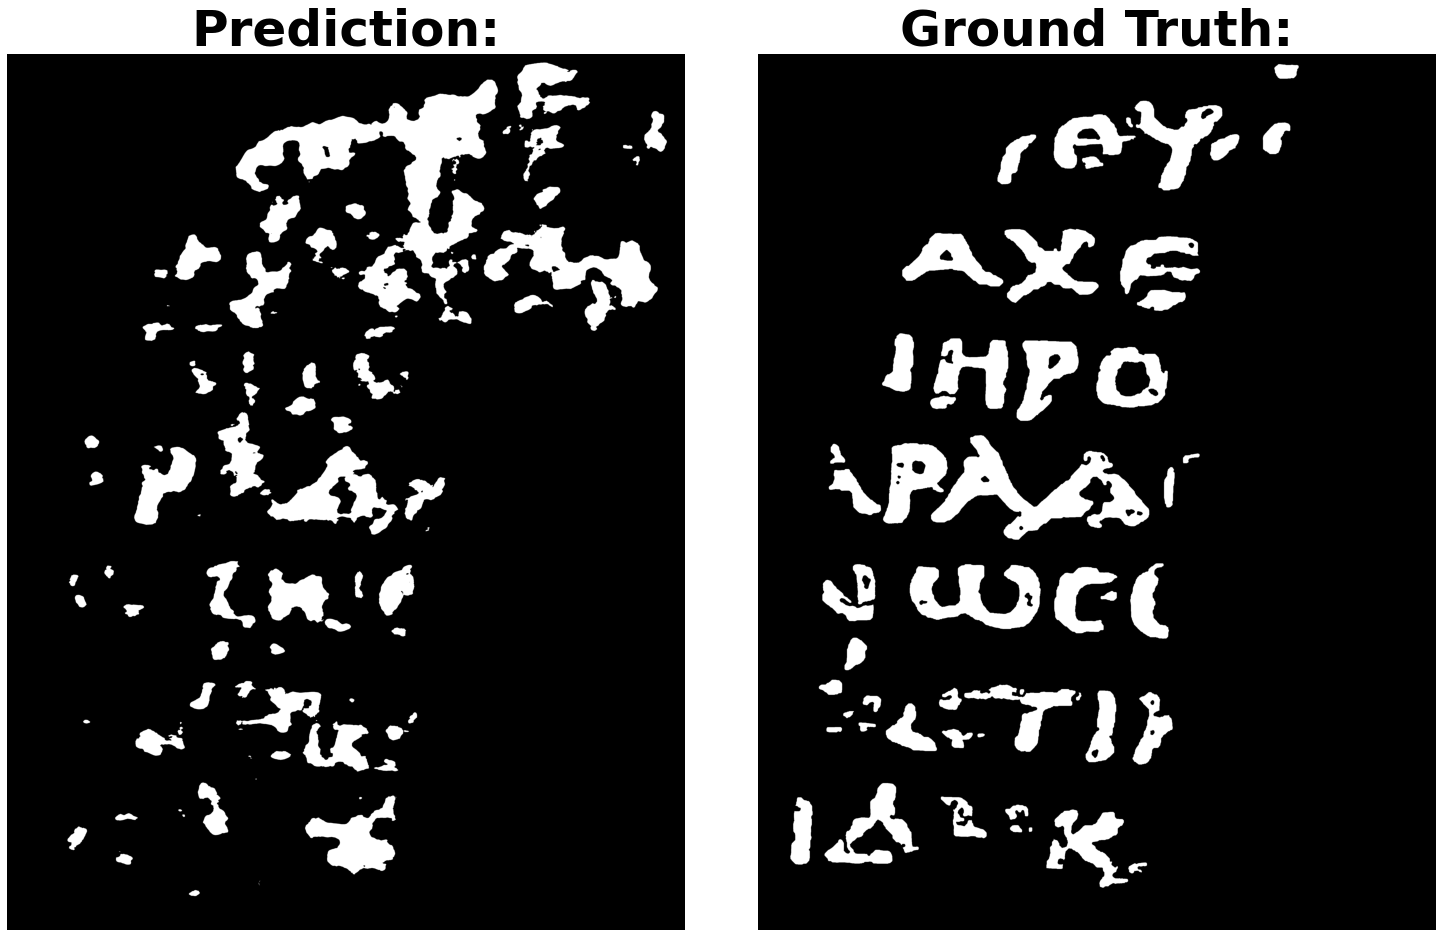

In [12]:
evaluate_fragment(1, model=model_1, threshold=0.75)

Preprocessing Data...


  0%|          | 0/30 [00:00<?, ?it/s]

Done;
Predicting 472 Files...


  0%|          | 0/236 [00:00<?, ?it/s]

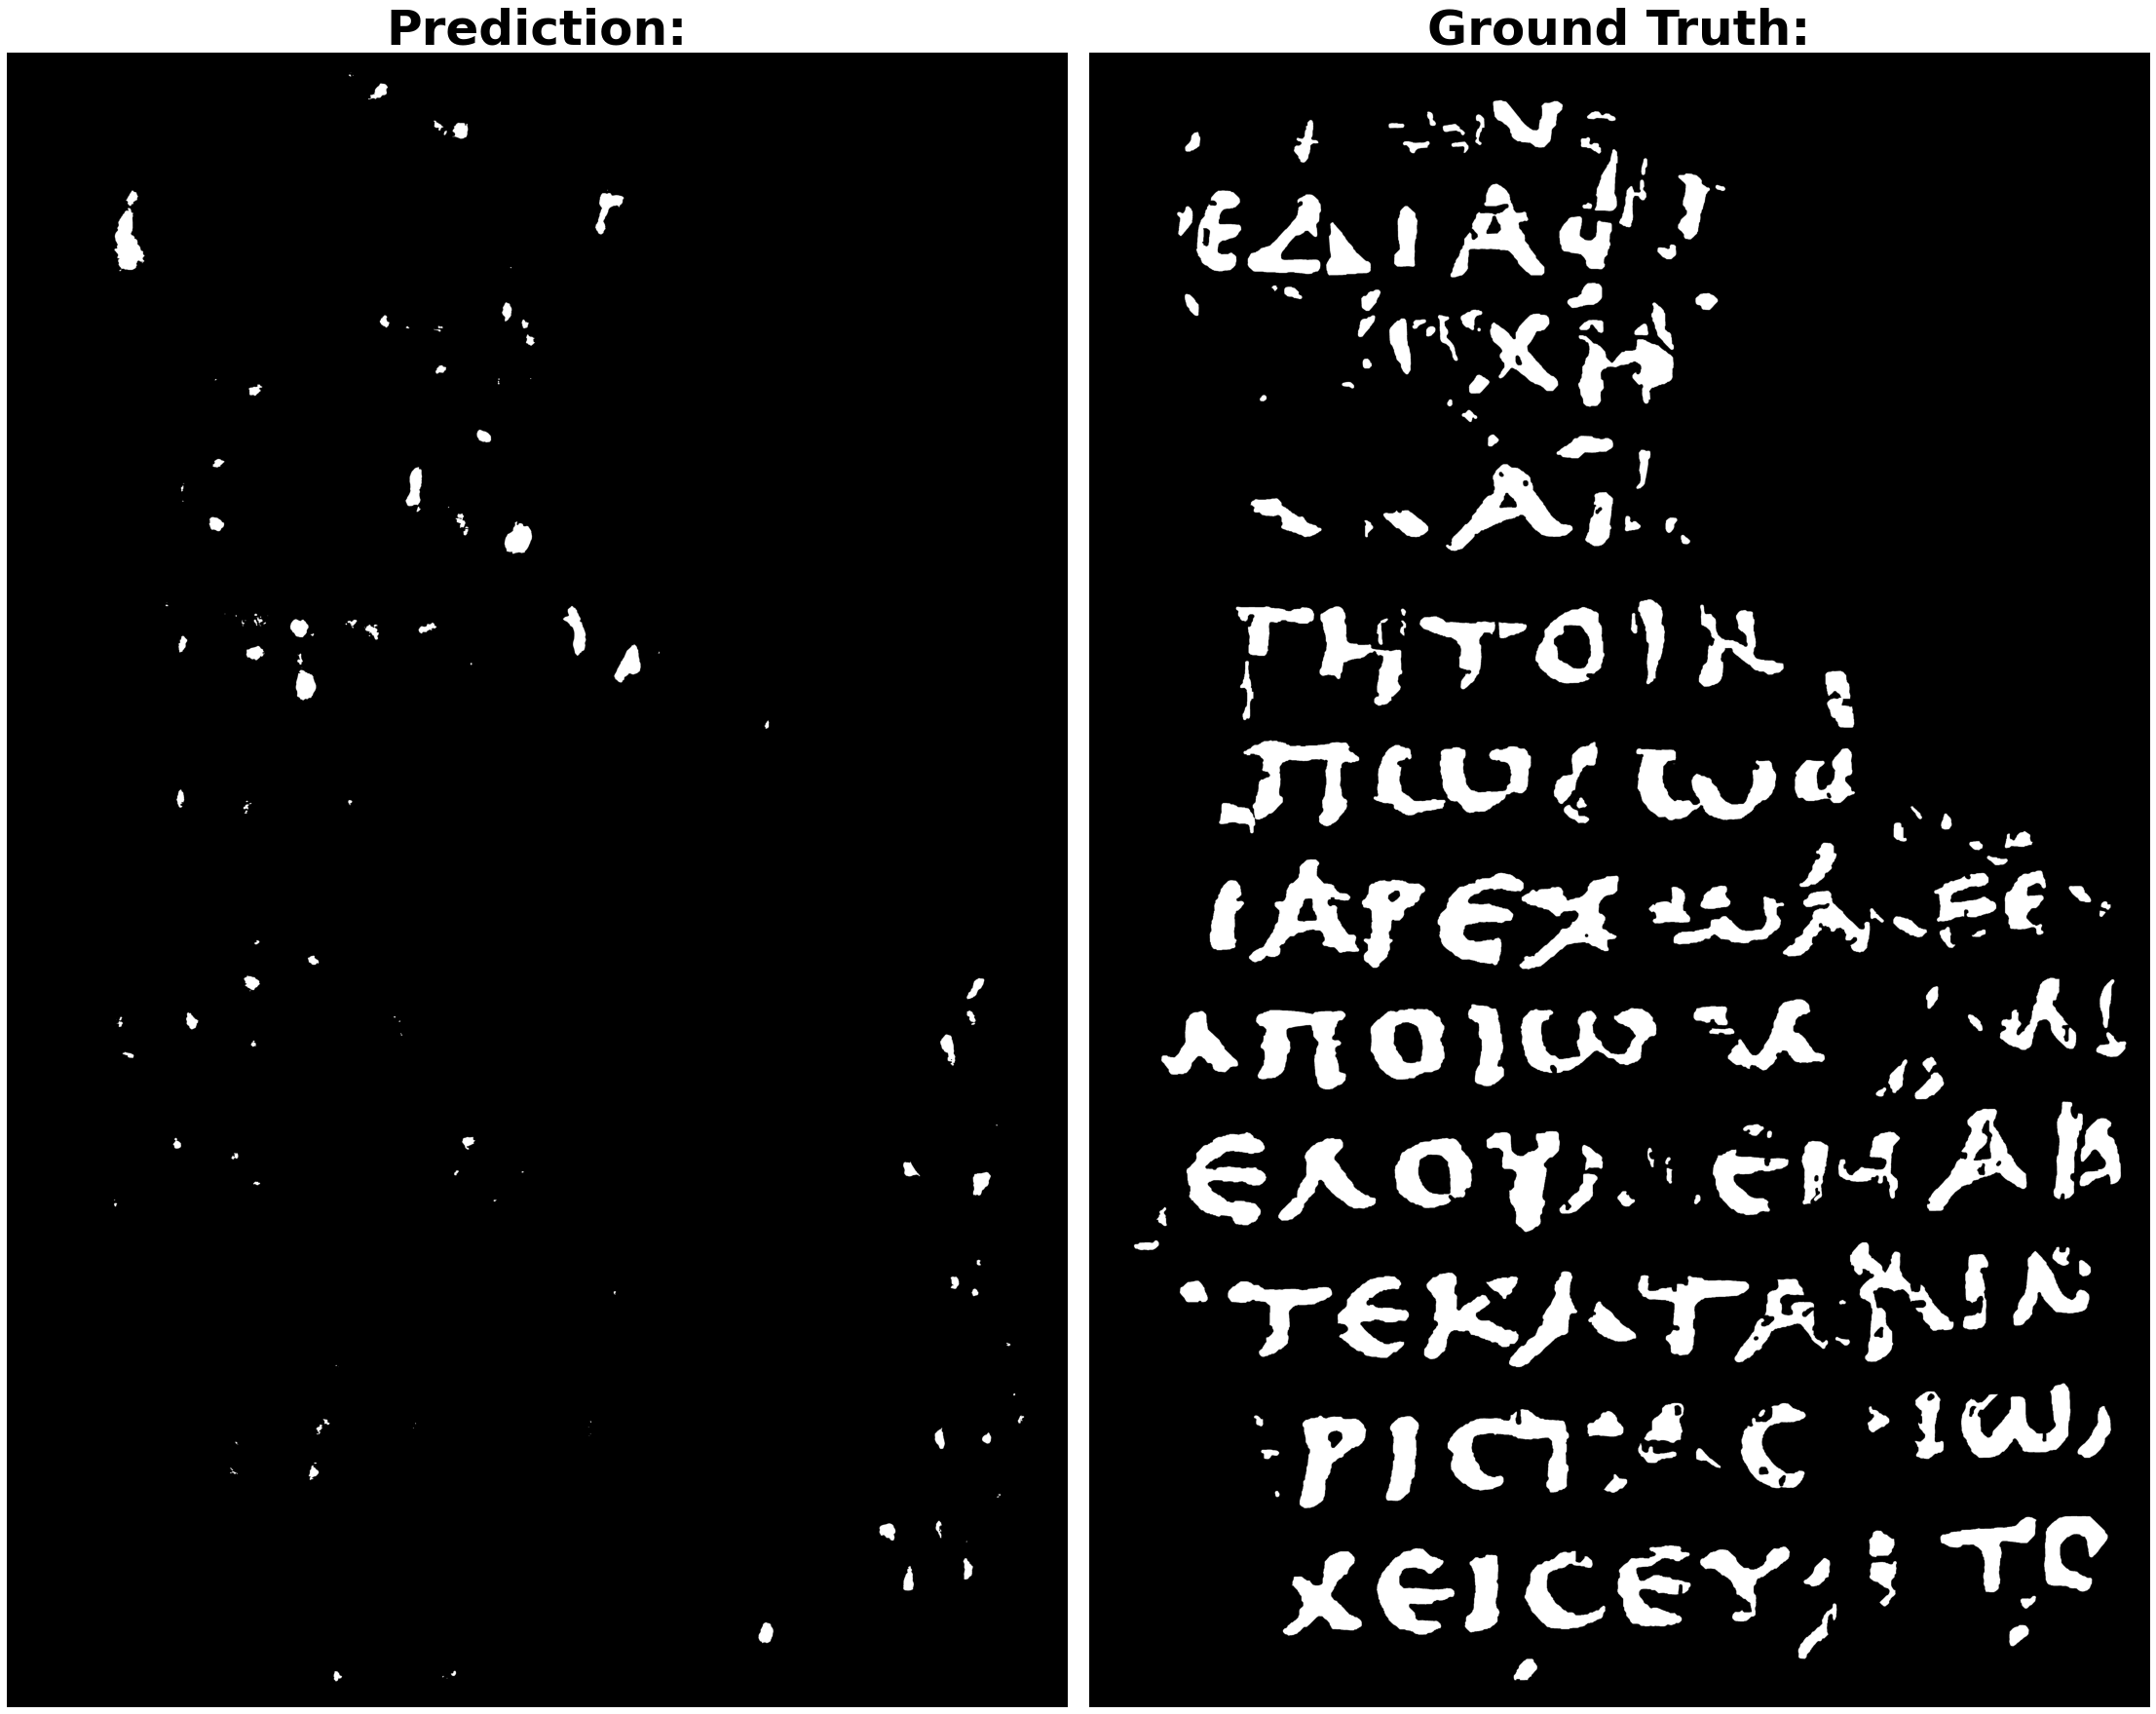

In [13]:
evaluate_fragment(2, model=model_2, threshold=0.2)

Preprocessing Data...


  0%|          | 0/16 [00:00<?, ?it/s]

Done;
Predicting 151 Files...


  0%|          | 0/76 [00:00<?, ?it/s]

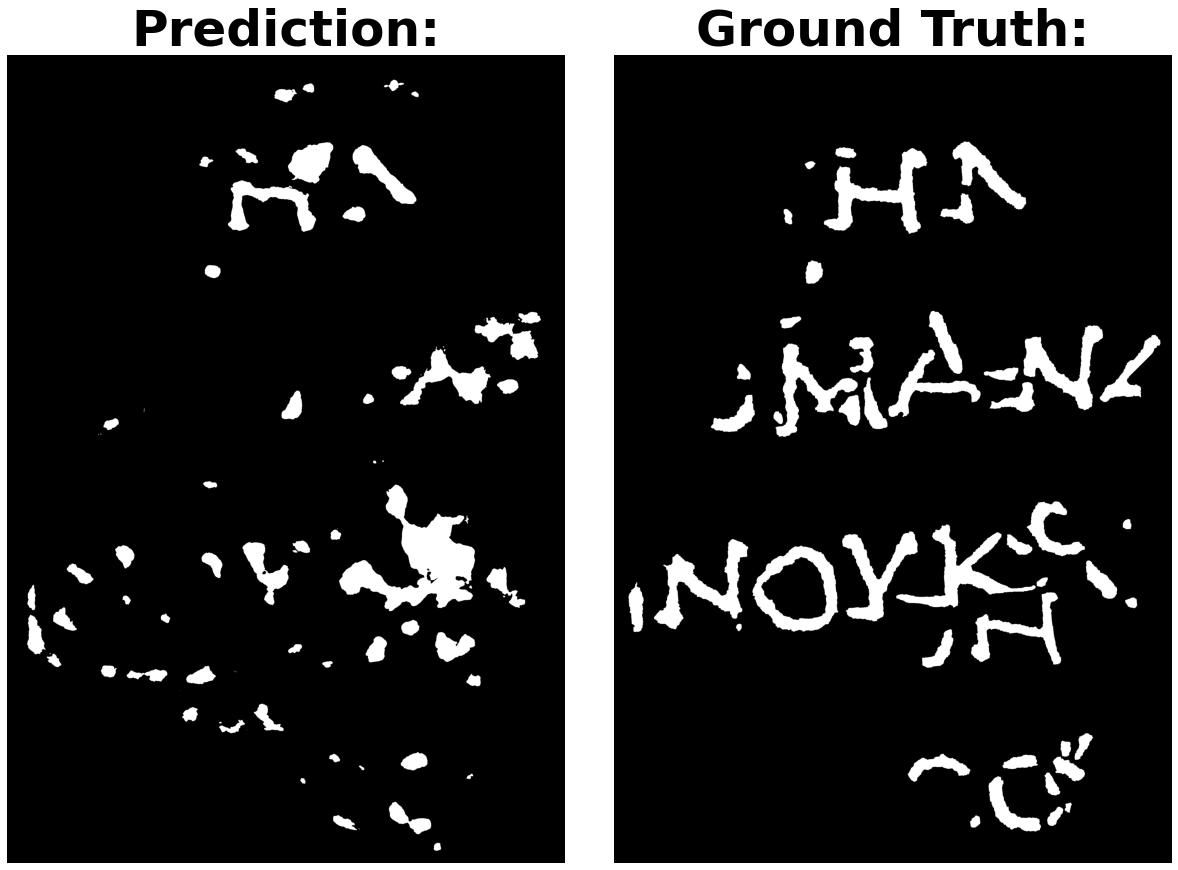

In [14]:
evaluate_fragment(3, model=model_3, threshold=0.7)